In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict

plt.style.use("dark_background")

### Util Classes and Functions

In [2]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (
        cumulative_sum[window_size:] - cumulative_sum[:-window_size]
    ) / window_size
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[: window_size - 1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

### Replay Buffer

In [3]:
class ReplayBuffer:
    """经验回放池"""

    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

### DQN

In [4]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [5]:
class DQN:
    """DQN算法"""

    def __init__(
        self,
        state_dim,
        hidden_dim,
        action_dim,
        learning_rate,
        gamma,
        epsilon,
        target_update,
        device,
    ):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict["states"], dtype=torch.float).to(
            self.device
        )
        actions = torch.tensor(transition_dict["actions"]).view(-1, 1).to(self.device)
        rewards = (
            torch.tensor(transition_dict["rewards"], dtype=torch.float)
            .view(-1, 1)
            .to(self.device)
        )
        next_states = torch.tensor(
            transition_dict["next_states"], dtype=torch.float
        ).to(self.device)
        dones = (
            torch.tensor(transition_dict["dones"], dtype=torch.float)
            .view(-1, 1)
            .to(self.device)
        )

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

### Training process

In [253]:
"""
struct Lot {
    lot_id:      string,
    wafer_type:  int,
    q_time:      int,
    priority:    uint_8,
    wafer_count: int
}
"""


class Lot:
    idx = {i: 9000 for i in range(1, 54)}

    def __init__(self):
        week = random.randint(1, 53)
        while Lot.idx[week] >= 10000:
            week = random.randint(1, 53)
        enable_qtime = bool(random.random() <= 0.1)
        self.lot_id = (
            "BP5"
            + (("0" + str(week)) if week < 10 else str(week))
            + str(Lot.idx[week])
            + ".00"
        )
        self.wafer_type = random.randint(1, 4)
        self.qtime = (
            max(0.0, random.normalvariate(2400, 250.0)) if enable_qtime else 0.0
        )
        self.priority = random.randint(0, 7)
        self.wafer_count = int(max(1.0, min(25.0, random.normalvariate(25.0, 15.0))))
        Lot.idx[week] += 1

    def __reset__(self):
        Lot.idx.clear()


class Env:
    reward_factor = [1.0, 0.5, 0.25, 0.2, 0.15, 0.1, 0.08, 0.05]

    def __init__(
        self,
        reward_threshold: float,
        max_steps: int,
        ratio: list[float],
        rpt: float = 0.0,
        num_lot: int = 1000,
    ):
        self.reward_threshold = reward_threshold
        self.max_steps = max_steps
        self.ratio = ratio
        self.rpt = rpt
        self.num_lot = num_lot
        self.wip_list = [Lot() for _ in range(num_lot)]
        self.terminated = 0.0
        self.step_id = 0
        ty_wip_list = [
            [x for x in self.wip_list if x.wafer_type == i + 1] for i in range(4)
        ]
        self.unordered_map = [
            OrderedDict(
                [(x.lot_id, x) for x in sorted(ty_wip_list[i], key=lambda x: x.lot_id)]
            )
            for i in range(4)
        ]
        self.ordered_qtime_map = [
            OrderedDict(
                [
                    (x.lot_id, x)
                    for x in sorted(ty_wip_list[i], key=lambda x: (x.qtime, x.lot_id))
                ]
            )
            for i in range(4)
        ]
        self.ordered_prior_map = [
            OrderedDict(
                [
                    (x.lot_id, x)
                    for x in sorted(
                        ty_wip_list[i], key=lambda x: (x.priority, x.lot_id)
                    )
                ]
            )
            for i in range(4)
        ]
        self.ordered_qtime_prior_map = [
            OrderedDict(
                [
                    (x.lot_id, x)
                    for x in sorted(
                        ty_wip_list[i], key=lambda x: (x.qtime, x.priority, x.lot_id)
                    )
                ]
            )
            for i in range(4)
        ]
        self.move = [0, 0, 0, 0]
        self.inventory = [0, 0, 0, 0]
        self.qtime_list = {i: [] for i in range(4)}
        self.elapsed = 0.0
        for lot in self.wip_list:
            self.inventory[lot.wafer_type - 1] += 1
            if lot.qtime > 0:
                self.qtime_list[lot.wafer_type - 1].append(
                    lot.qtime
                )  # TODO: How to model the qtime in terms of some data structures
        """
        State: [mv_type1%, mv_type2%, mv_type3%, mv_type4%, elapsed / min(qtime_list[i]) ...]
        """
        self.state = [
            move_ty / sum(self.move) if sum(self.move) > 0 else 0
            for move_ty in self.move
        ] + [self.elapsed / min(self.qtime_list[i]) for i in range(4)]

    def reset(self) -> list[float]:
        ty_wip_list = [
            [x for x in self.wip_list if x.wafer_type == i + 1] for i in range(4)
        ]
        self.unordered_map = [
            OrderedDict(
                [(x.lot_id, x) for x in sorted(ty_wip_list[i], key=lambda x: x.lot_id)]
            )
            for i in range(4)
        ]
        self.ordered_qtime_map = [
            OrderedDict(
                [
                    (x.lot_id, x)
                    for x in sorted(ty_wip_list[i], key=lambda x: (x.qtime, x.lot_id))
                ]
            )
            for i in range(4)
        ]
        self.ordered_prior_map = [
            OrderedDict(
                [
                    (x.lot_id, x)
                    for x in sorted(
                        ty_wip_list[i], key=lambda x: (x.priority, x.lot_id)
                    )
                ]
            )
            for i in range(4)
        ]
        self.ordered_qtime_prior_map = [
            OrderedDict(
                [
                    (x.lot_id, x)
                    for x in sorted(
                        ty_wip_list[i], key=lambda x: (x.qtime, x.priority, x.lot_id)
                    )
                ]
            )
            for i in range(4)
        ]
        self.move = [0, 0, 0, 0]
        self.inventory = [0, 0, 0, 0]

        self.qtime_list = {i: [] for i in range(4)}
        self.elapsed = 0.0
        self.step_id = 0
        self.terminated = 0.0
        for lot in self.wip_list:
            self.inventory[lot.wafer_type - 1] += 1
            if lot.qtime > 0:
                self.qtime_list[lot.wafer_type - 1].append(lot.qtime)

        self.state = [
            move_ty / sum(self.move) if sum(self.move) > 0 else 0
            for move_ty in self.move
        ] + [self.elapsed / min(self.qtime_list[i]) for i in range(4)]

        return self.state + [self.terminated]

    def step(self, action: int) -> list[float]:
        """Action
        represent in 4 bits xxxx
        first 2 bits represent type: 0, 1, 2, 3
        the third bit: if enable qtime ordering
        the last bit: if enable priority ordering
        reward priority factor = 0: 1.0 / 1: 0.5 / 2: 0.25 / 3: 0.2 / 4: 0.15 / 5: 0.1 / 6: 0.08 / 7: 0.05
        """
        if self.terminated == 1.0:
            return self.state + [0.0, self.terminated]
        type_id = action >> 2
        enable_qtime = action & (1 << 1)
        enable_priority = action & 1
        lot_id: str
        lot: Lot
        reward = 0.0
        if not enable_qtime and not enable_priority:
            lot_id, lot = self.unordered_map[type_id].popitem(last=False)
            self.ordered_prior_map[type_id].pop(lot_id)
            self.ordered_qtime_map[type_id].pop(lot_id)
            self.ordered_qtime_prior_map[type_id].pop(lot_id)
        elif enable_qtime and not enable_priority:
            lot_id, lot = self.ordered_qtime_map[type_id].popitem(last=False)
            self.unordered_map[type_id].pop(lot_id)
            self.ordered_prior_map[type_id].pop(lot_id)
            self.ordered_qtime_prior_map[type_id].pop(lot_id)
        elif not enable_qtime and enable_priority:
            lot_id, lot = self.ordered_prior_map[type_id].popitem(last=False)
            self.unordered_map[type_id].pop(lot_id)
            self.ordered_qtime_map[type_id].pop(lot_id)
            self.ordered_qtime_prior_map[type_id].pop(lot_id)
        else:
            lot_id, lot = self.ordered_qtime_prior_map[type_id].popitem(last=False)
            self.unordered_map[type_id].pop(lot_id)
            self.ordered_qtime_map[type_id].pop(lot_id)
            self.ordered_prior_map[type_id].pop(lot_id)
        self.move[type_id] += lot.wafer_count
        self.inventory[type_id] -= lot.wafer_count
        self.elapsed += lot.wafer_count * self.rpt
        self.state = [
            move_ty / sum(self.move) if sum(self.move) > 0 else 0
            for move_ty in self.move
        ] + [self.elapsed / min(self.qtime_list[i]) for i in range(4)]
        self.step_id += 1

        if self.step_id > self.max_steps or max(self.state[-4:]) >= 1:
            self.terminated = 1.0

        loss = (
            sum(
                [
                    (self.state[i] - self.ratio[i] / sum(self.ratio)) ** 2
                    for i in range(4)
                ]
            )
            / 4
        )

        if loss <= self.reward_threshold:
            reward = 1.0 * Env.reward_factor[lot.priority]

        return self.state + [reward, self.terminated]

In [254]:
lr = 2e-4
num_episodes = 1000
num_epochs = 10
hidden_dim = 256
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 512
minimal_size = 256
batch_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env = Env(0.025, 1000, [1.0, 3.0, 4.0, 1.0], 1.0, 1000)
env_name = "Dispatching Rule"
# env = gym.make(env_name)
# env.spec.max_episode_steps = 1000
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
# state_dim = (
#     env.observation_space.shape[0] if env.observation_space.shape is not None else 0
# )
# action_dim = env.action_space.n
state_dim = 8
action_dim = 16
agent = DQN(
    state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device
)

return_list = []
for i in range(num_epochs):
    with tqdm(total=int(num_episodes / num_epochs), desc="Iteration %d" % i) as pbar:
        for i_episode in range(int(num_episodes / num_epochs)):
            episode_return = 0
            _state = env.reset()
            state, done = _state[:state_dim], _state[-1] == 1.0
            while not done:
                action = agent.take_action(state)
                _state = env.step(action)
                next_state, reward, done = (
                    _state[:state_dim],
                    _state[-2],
                    _state[-1] == 1.0,
                )
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        "states": b_s,
                        "actions": b_a,
                        "next_states": b_ns,
                        "rewards": b_r,
                        "dones": b_d,
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % num_epochs == 0:
                pbar.set_postfix(
                    {
                        "episode": "%d"
                        % (num_episodes / num_epochs * i + i_episode + 1),
                        "return": "%.3f" % np.mean(return_list[-num_epochs:]),
                    }
                )
            pbar.update(1)

Iteration 9: 100%|██████████| 100/100 [00:06<00:00, 14.99it/s, episode=1000, return=93.770]


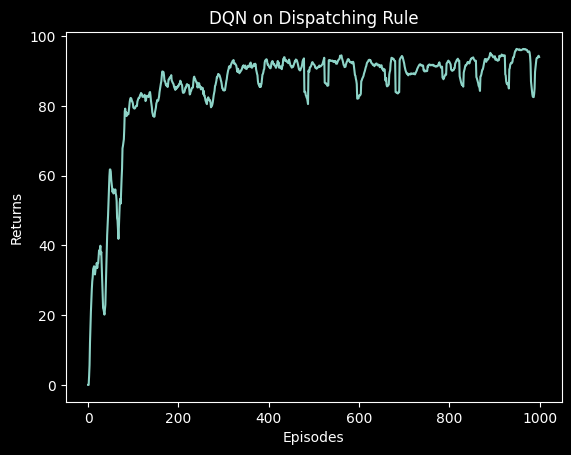

In [255]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, moving_average(return_list, 9))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("DQN on {}".format(env_name))
plt.show()

In [148]:
s = env.reset()

In [149]:
agent.take_action(s[:8])

6

In [196]:
s = env.step(13)
s

[0.10062893081761007,
 0.14465408805031446,
 0.5073375262054507,
 0.24737945492662475,
 1.0090092748734902,
 0.8672517789726818,
 0.9444182332281401,
 0.779844766998057,
 1.0,
 1.0]

In [197]:
agent.take_action(s[:8])

13